### Necessary libraries

In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier


## Preprocessing

In [2]:
files = ['gossipcop_fake.csv', 'gossipcop_real.csv', 'politifact_fake.csv', 'politifact_real.csv']
dfs = []
dfs_fake = []
dfs_real = []
for f in files:
    df = pd.read_csv(f)
    if f[-8:-4] == 'fake':
        df['label'] = ['fake' for _ in range(len(df))]
        dfs_fake.append(df)
    else:
        df['label'] = ['real' for _ in range(len(df))]
        dfs_real.append(df)
    dfs.append(df)
new_df = pd.concat(dfs, ignore_index=True)
final_df = new_df[['label', 'title']]
final_df['num_char'] = final_df['title'].str.len()
final_df['num_word'] = [len(x.split()) for x in final_df['title']]

#Attempting to keep a more balanced spread between real and fake news instances


real =  pd.concat(dfs_real, ignore_index=True)
real_df = real[['label', 'title']]
real_sample  = real_df.sample(n=1000, random_state=42)

fake = pd.concat(dfs_fake, ignore_index=True)
fake_df = fake[['label', 'title']]
fake_sample  = fake_df.sample(n=1000, random_state=42)

full_sample = pd.concat([fake_sample, real_sample], ignore_index=True)

/Users/noahweinstein/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/noahweinstein/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Data Examination 

In [3]:
total=sum([1 for x in final_df['title'].isna() if x== True])
print(f'there are {total} NAN in dataset')

there are 0 NAN in dataset


In [4]:
final_df.head()

num_fake = sum([1 for x in final_df['label'] if x=='fake'])
num_real = len(final_df)-num_fake

In [5]:
px.histogram(data_frame=final_df, x = 'label', title = 'Fake vs real news counts')

In [6]:
group = final_df.groupby(['label']).sum()


([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

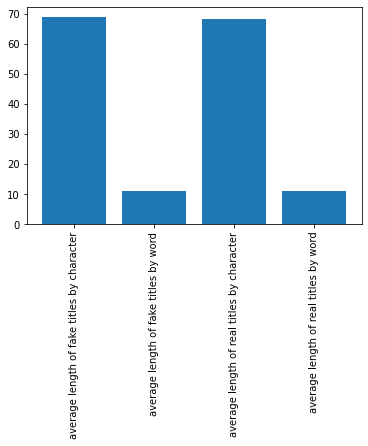

In [7]:
avg_char_fake = group['num_char']['fake']/num_fake
avg_word_fake = group['num_word']['fake']/num_fake

avg_char_real = group['num_char']['real']/num_real
avg_word_real = group['num_word']['real']/num_real

x = ['average length of fake titles by character', 'average length of fake titles by word', 'average length of real titles by character', 'average length of real titles by word']

y = [avg_char_fake, avg_word_fake, avg_char_real, avg_word_real]

plt.bar(x, y)
plt.xticks(rotation=90)

In [8]:
full_corp = []
corpus = [word_tokenize(x) for x in final_df['title']]
for title in corpus:
    full_corp.extend(title)
print(len(full_corp))




294883


## Application

In [9]:
#'real' or 'fake' to binary
def to_binary(in_list):

    return [1 if x=='fake' else 0 for x in in_list]

#binary to 'real' or 'fake'
def from_binary(in_list):
    return ['fake' if x==1 else 'real' for x in in_list]

For the scikit-learn Decision Tree Classifier model, we get the following metrics:
Accuracy: 0.59
Precision: 0.8070175438596491
Recall: 0.23115577889447236
f1: 0.359375
For the scikit-learn Random Forest Classifier model, we get the following metrics:
Accuracy: 0.7075
Precision: 0.7530864197530864
Recall: 0.6130653266331658
f1: 0.6759002770083102


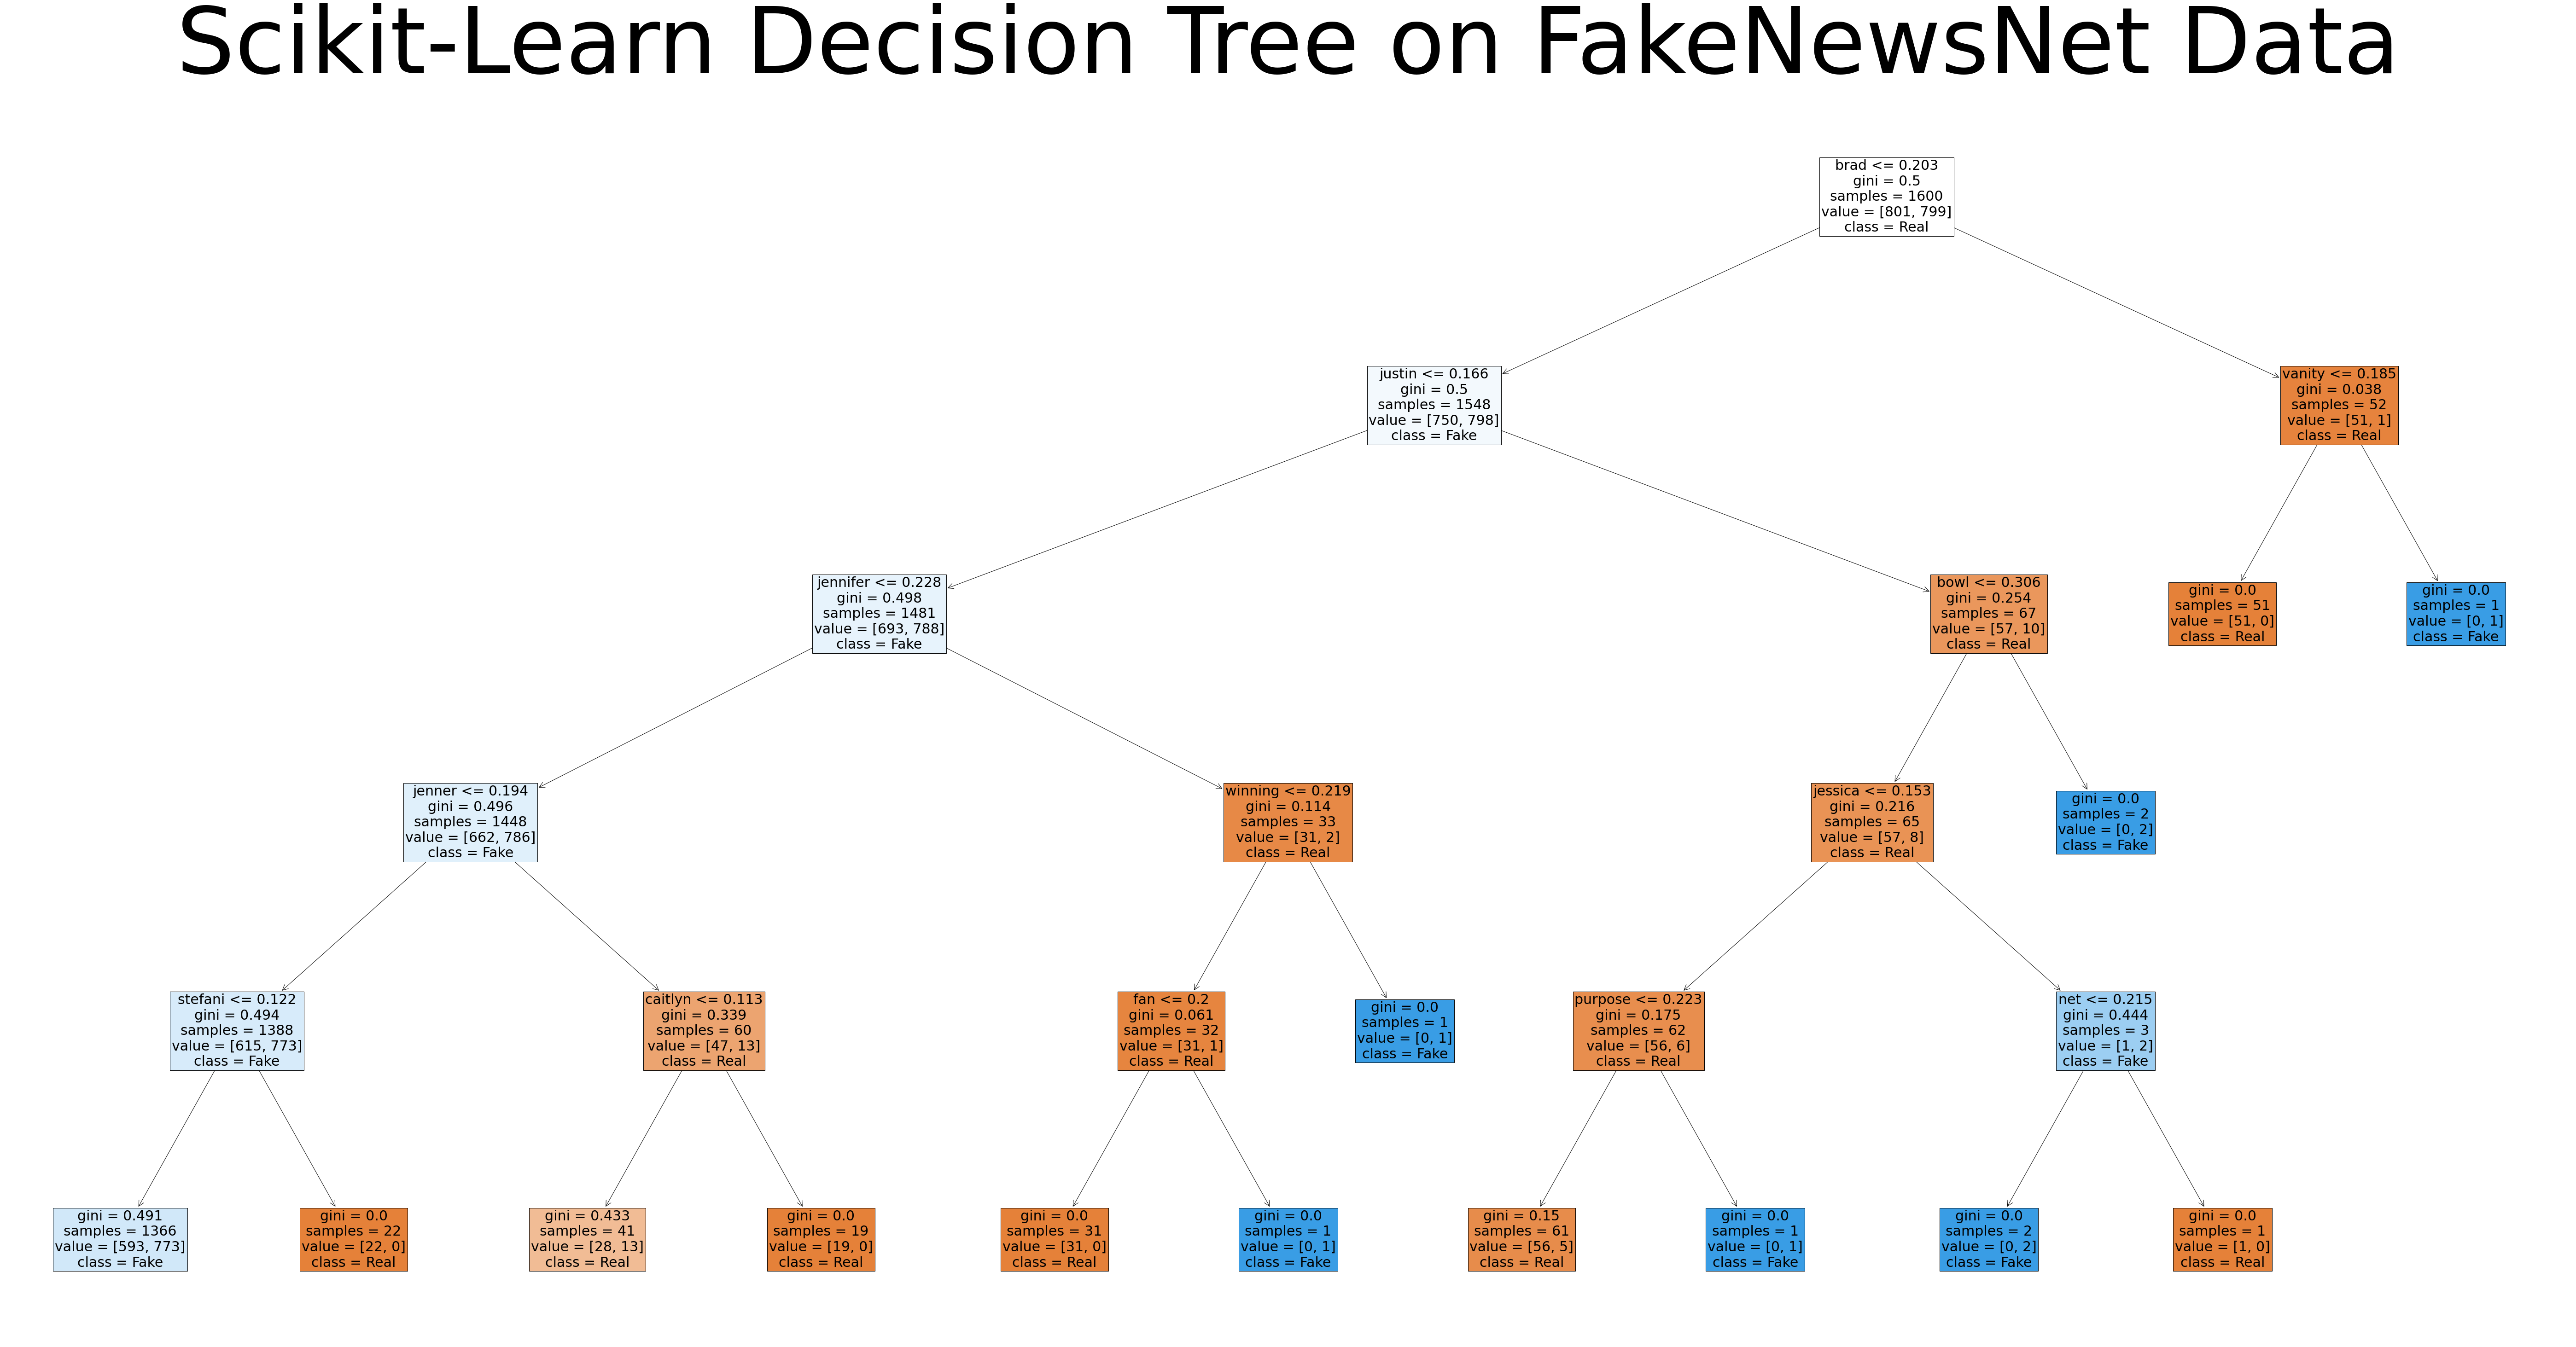

In [10]:
from sklearn import tree
import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(full_sample['title'], full_sample['label'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

dt_feature_names = vectorizer.get_feature_names_out()

classifiers = {"Decision Tree Classifier": DecisionTreeClassifier(max_depth=5, random_state=42), 
               "Random Forest Classifier": RandomForestClassifier(n_estimators=100, random_state=42)}


for name, model in classifiers.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(to_binary(y_test), to_binary(y_pred), average='binary')
    recall = recall_score(to_binary(y_test), to_binary(y_pred), average='binary')
    f1 = f1_score(to_binary(y_test), to_binary(y_pred), average='binary')
    #report = classification_report(y_test, y_pred)
    print(f"For the scikit-learn {name} model, we get the following metrics:")
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'f1: {f1}')

#text_representation = tree.export_text(classifiers["Decision Tree Classifier"])
plt.figure(figsize=(100, 50))
tree.plot_tree(classifiers["Decision Tree Classifier"], feature_names=dt_feature_names, class_names=["Real", "Fake"], filled=True, fontsize=30)
plt.title("Scikit-Learn Decision Tree on FakeNewsNet Data", fontsize= 200)
plt.show()


In [11]:
from random_forest import RandomForest
from Decision_Tree import DecisionTree

dt = DecisionTree()
print(X_train_tfidf.shape)
print(X_train_tfidf.toarray())

dt.fit(X_train_tfidf.toarray(), to_binary(y_train))




(1600, 4410)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0
best_feature 534
best_thresh 0.22032482156995511
1
best_feature 2100
best_thresh 0.22815357862090715
2
best_feature 3494
best_thresh 0.19457253575626499
3
best_feature 2156
best_thresh 0.17221703020036633
4
best_feature 644
best_thresh 0.19705410145182872
5
best_feature 1763
best_thresh 0.2559147458384701
6
best_feature 2161
best_thresh 0.21963836667949158
7
best_feature 3272
best_thresh 0.1824016324349915
8
best_feature 4109
best_thresh 0.15423806122321457
9
best_feature 3627
best_thresh 0.23835022088323693
10
best_feature 338
best_thresh 0.18625876680114245
11
best_feature 1770
best_thresh 0.28911968926982634
12
best_feature 3238
best_thresh 0.23503929550386718
13
best_feature 2735
best_thresh 0.2527415023142266
14
best_feature 1408
best_thresh 0.19709851253808053
15
best_feature 1062
best_thresh 0.21296247139767233

In [12]:
preds  = from_binary(dt.predict(X_test_tfidf.toarray()))
preds



['fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'real',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'fake',
 'real',
 'fake',
 'real',
 'real',
 'fake',
 

In [13]:
y_test

1860    real
353     fake
1333    real
905     fake
1289    real
        ... 
965     fake
1284    real
1739    real
261     fake
535     fake
Name: label, Length: 400, dtype: object